# Final Project Submission

* Student name: Charlie Jin, Max Ross, Gideon Miles
* Student pace: Full time
* Scheduled project review date/time: Mar 31
* Instructor name: Daniel
* Blog post URL:

# Seattle Flips Real Estate Analysis

![img](https://www.compass.com/m/29fb5871c58d7a92cb3a4aa6d45f999f87a70b3b_img_0/640x480.webp)

# Overview

Our project analyzes the marketplace for real estate in the city of Seattle.   Seattle Flips real estate company needs to know that their houses are to be sold with maximum profit.   Our project will result in findings relevant for knowledge of the Seattle marketplace, breaking down individual components that helps and relates to a house being sold.

# Business Problem

Seattle Flips is currently trying to find out how to sell their houses.  They are confused with the data that they currently have, making economic sense of it.   Our job is to create the best plan of action to sell these houses for maximum profit.

# Part 1. Data Cleaning

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.stats.stattools
from statsmodels.graphics.regressionplots import abline_plot

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

In [120]:
df = pd.read_csv('data/kc_house_data.csv')
#df.info()

# Converting column dtypes

In [121]:
# converting date column from str to int
df['date'] = pd.to_datetime(df['date']).dt.year
#df.info()

In [122]:
#extracting zip code from address and converting to int
df['zipcode'] = df['address'].str.extract(r'\b(\d{5})[,]\s*United States\b').astype('int')

In [123]:
# lambda function to extract the first character of each object and convert it to an int.
extract_num = lambda x: int(x[:2])

# Apply the lambda function
df['grade'] = df['grade'].apply(extract_num)

In [124]:
df['nuisance'] = df['nuisance'].map({'YES': 0, 'NO': 1})
df['greenbelt'] = df['greenbelt'].map({'YES': 1, 'NO': 0})
df['waterfront'] = df['waterfront'].map({'YES': 1, 'NO': 0})

In [125]:
#df['yr_renovated'] = df['yr_renovated'].astype(int)

In [126]:
# 1 is not renovated
df['renovated'] = (df['yr_renovated'] == 0).astype(int)

# Filtering out rows not in King County

In [127]:
#filtering out adresses not in Washington
df_wash = df[df['address'].str.contains('Washington')]
#df_wash.info()

#### URL for King County Coordinate info
[King County Coordinates and Zipcode info](https://www5.kingcounty.gov/sdc/FGDCDocs/ZIPCODE_fgdc.htm)

In [128]:
df_king = df_wash[(df_wash['lat'] >= 46.71) 
                       & (df['lat'] <= 48.31) 
                       & (df['long'] >= -123.07) 
                       & (df['long'] <= -119.90)]
#df_king.info()

# Dropping Null, Duplicate, Dropping Possible high Corrilinearity and Unecessary Columns

In [129]:
df_king.drop_duplicates(inplace=True)
#df_king.info()

In [130]:
df_king.dropna(inplace=True)
#df_king.info()

In [131]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=df_king.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [132]:
#print(df[(df.cc>.50) & (df.cc <1)])

In [133]:
df_king.drop(['id', 'address', 'sqft_above', 'sqft_basement', 'bathrooms', 'grade', 'bedrooms',
              'sqft_garage', 'floors'], axis=1, inplace=True)
#df_king.info()

# Part 2. Data Understanding

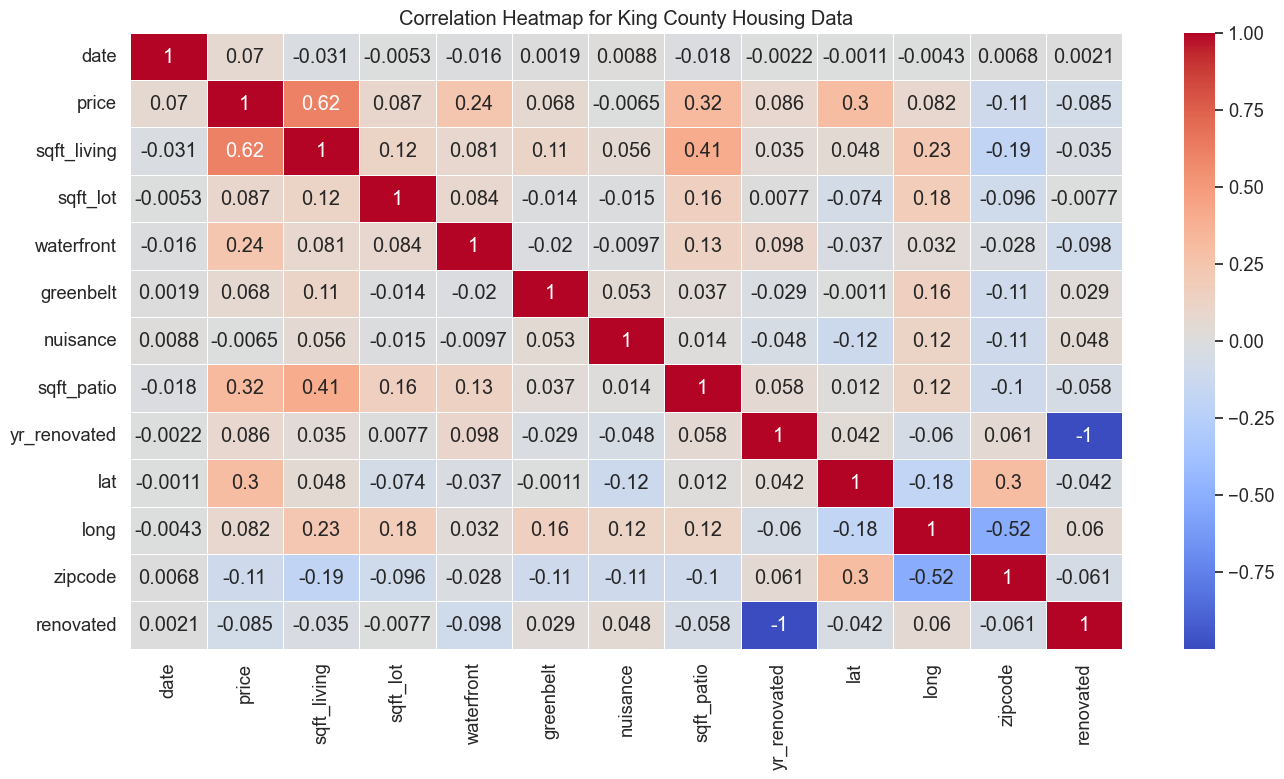

In [17]:
corr_matrix = df_king.corr(method='pearson')

sns.set(font_scale=1.2)
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for King County Housing Data")
plt.show()

# Part 3. Creating Our Initial Model: Simple Base Model

### Examining the heatmap, it appears that the Square Feet of Living Space in a home exhibits the strongest correlation coefficient with respect to housing prices. Consequently, using this feature as the basis for a model is logical, as one would intuitively assume that the size of a home, measured in square feet, significantly influences its price.

#sns.lmplot(data=df_king, x='sqft_living', y='price', hue='smoker')
sns.regplot(data=df_king, x="sqft_living", y="price")
plt.xlabel('SQFT Living')
plt.ylabel('House Price per Mil')
plt.title('Price vs SQFT Correlation');

#### Seems to be a clear relationship


In [18]:
y = df_king['price']
X = df_king['sqft_living']

base_model = sm.OLS(y, sm.add_constant(X)).fit()


print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.792e+04
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:04   Log-Likelihood:            -4.3459e+05
No. Observations:               29197   AIC:                         8.692e+05
Df Residuals:                   29195   BIC:                         8.692e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.227e+04   9904.112     -9.317      

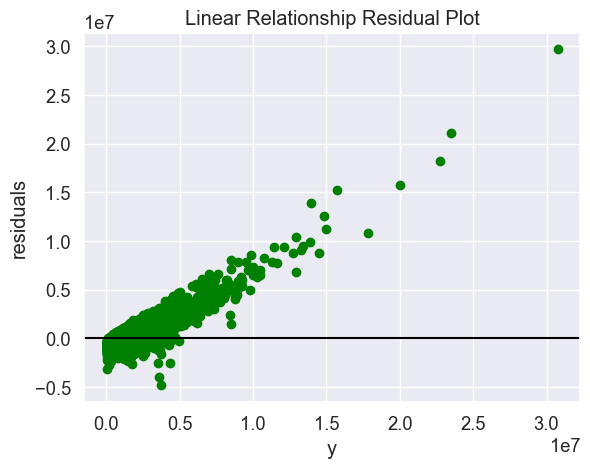

In [19]:
fig, ax = plt.subplots()

ax.scatter(y, base_model.resid, color="green")
ax.axhline(y=0, color="black")
ax.set_xlabel("y")
ax.set_ylabel("residuals")
ax.set_title("Linear Relationship Residual Plot");

In [20]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(base_model.resid, sm.add_constant(X))

(343.0170136794144,
 1.405487885283857e-76,
 347.07103414867214,
 5.152148079099692e-77)

#### Assumption Tests and Analysis:
- Passes **multicollinearity** with cond. no. 132 (under 1,000)
- Passes **independence** with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
- Fails **normality** Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
- Slightly skewed left
- 9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

# Part 4. Assumption Testing 

## 1. Linearity Residual plots

eval_env: 1
eval_env: 1


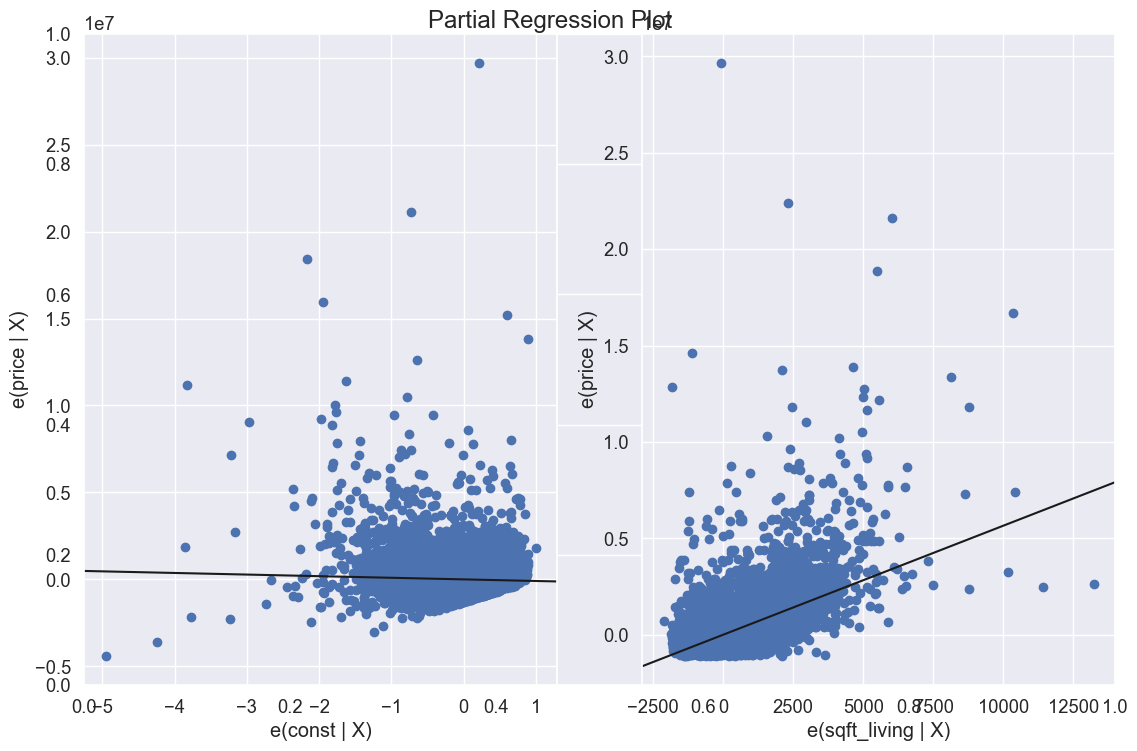

In [21]:

# Partial regression plots
fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.plot_partregress_grid(base_model, fig=fig)
plt.show()

In [22]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(base_model)

(1.21678899987318, 1.1605640760109688e-32)

## Based on our q-q plot and linear rainbow diagnostic we cann assume that our linear regression model has satisfied the Linear Assumption

## II. **Normality Assumption**: Assumes that residuals or errors are normally distributed.

- The **Omnibus test** is used to detect normality assumption. A low probability value suggests that the distribution of errors or residuals is not normal. In this case, the p-value for the Omnibus test is 0.000 which means that we can reject the null hypothesis of normal distribution of residuals and conclude that the normality assumption is violated.
- **Jarque-Bera** (JB) test is also used to check for normality assumption. The JB test statistic measures whether the data has skewness or kurtosis values matching a normal distribution. If the test statistic is large and/or the p-value is low, then skewness and/or kurtosis are not similar to a normal distribution. With a very large test statistic of 50073454.459 and the p-value of 0.00, we can reject the null hypothesis of normality, indicating a violation of normality assumption.
- **Skewness** measures the degree of asymmetry of a probability distribution. A symmetrical distribution will have a skewness of 0. Positive skewness means there are more observations on the left side of the distribution, while negative means more observations on the right side. Here, the skewness value of 8.237 indicates positive skewness.
- **Kurtosis** measures the degree of peakness of a probability distribution. A normal distribution has a kurtosis of 3, and if it is greater than 3, it is said to be leptokurtic or heavy-tailed, and if it is less than 3, it is said to be platykurtic or light-tailed. The value of Kurtosis here is exceptionally high at 205.252 reflecting a severe deviation from normality.

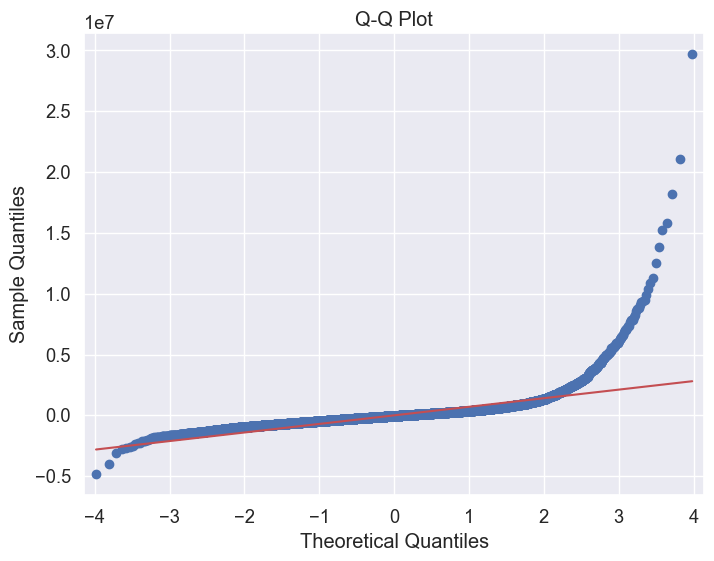

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(base_model.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

In [24]:
base_model.summary().tables[2]

Omnibus:,42260.401,Durbin-Watson:,1.938
Prob(Omnibus):,0.000,Jarque-Bera (JB):,50099131.216
Skew:,8.237,Prob(JB):,0.00
Kurtosis:,205.263,Cond. No.,5.63e+03


#### with omnibus and Jarque-Bera having small p-values this suggests that we cannot reject the null-hypothesis that the base model data is normally distributed.
#### Also with a Kurtosis greater than 3 this would suggest that the distribution is heavilyt tailed/spread out
#### Therefore this model does not pass normality assumption and we can not assume that this model is normally distributed

## III.Homoscedasticity Assumption: Assumes that the variance of residuals is constant across observations or independent variable values.
- need to look into this

In [25]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(base_model.resid, sm.add_constant(X))

(343.0170136794144,
 1.405487885283857e-76,
 347.07103414867214,
 5.152148079099692e-77)

#### larger p-values for Lagrange Multiplier and Breuschpagan suggest that this base model passes Homoscedasticity Assumption

# IV. Independence

In [26]:
resids = base_model.resid 
dw = sm.stats.stattools.durbin_watson
dw(resids)

1.9375848458582323

#### A score of almost 2 indicates that there is no autocorrelation and therefore passess the independence assumption

# V. Testing multiple regression models

## I. One-Hot encoding categorical data to see if any sub category has a stronger correlation with price than current variables (these categorical columns were not on scale like 'grade' and 'condition' and the boolean categories)
#### Categorical columns:
- zipcode
- heat_source
- sewer_system

#### A. Zipcodes

In [27]:
df_dummy_zip = df_king.copy()

In [28]:
# Get unique zipcodes
unique_zipcodes = df_dummy_zip['zipcode'].unique()

# Convert column 'zipcode' into dummy columns
df_zip = pd.get_dummies(df_dummy_zip, columns=['zipcode'], prefix='zip')

# Create a list of new dummy zipcode columns
zip_col = [f'zip_{zipcode}' for zipcode in unique_zipcodes]

# Define the most correlated column
most_correlated = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated = df_zip[[most_correlated] + zip_col]

In [29]:
#X_iterated.corr()['price'].sort_values(ascending=False).head(10)

In [30]:
zip_dummy_base = X_iterated.drop('zip_98042', axis=1)

In [31]:
iterated_model = sm.OLS(y, sm.add_constant(zip_dummy_base))
iterated_results = iterated_model.fit()
print(iterated_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     482.3
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:08   Log-Likelihood:            -4.2854e+05
No. Observations:               29197   AIC:                         8.573e+05
Df Residuals:                   29109   BIC:                         8.580e+05
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.222e+05      2e+04    -16.145      

#### B. Heat_Source

In [32]:
df_dummy_heat = df_king.copy()

In [33]:
# Get unique zipcodes
heat_systems = df_dummy_heat['heat_source'].unique()

# Convert column 'zipcode' into dummy columns
df_heat = pd.get_dummies(df_dummy_heat, columns=['heat_source'], prefix='heat_source')

# Create a list of new dummy zipcode columns
heat_col = [f"heat_source_{heat_source}" for heat_source in heat_systems]

# Define the most correlated column
most_correlated2 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated2 = df_heat[[most_correlated2] + heat_col]

In [34]:
df_dummy_heat['heat_source'].value_counts()

Gas                  20167
Electricity           5957
Oil                   2899
Gas/Solar               93
Electricity/Solar       57
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

In [35]:
X_iterated2.corr()['sqft_living'].sort_values(ascending=False)

sqft_living                      1.000000
heat_source_Gas                  0.265354
heat_source_Gas/Solar            0.031197
heat_source_Oil/Solar           -0.003226
heat_source_Other               -0.005770
heat_source_Electricity/Solar   -0.006623
heat_source_Oil                 -0.151270
heat_source_Electricity         -0.195252
Name: sqft_living, dtype: float64

In [36]:
heat_dum_base = X_iterated2.drop('heat_source_Gas', axis=1)

In [37]:
iterated_model2 = sm.OLS(y, sm.add_constant(heat_dum_base))
iterated_results2 = iterated_model2.fit()
print(iterated_results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     2569.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:09   Log-Likelihood:            -4.3457e+05
No. Observations:               29197   AIC:                         8.692e+05
Df Residuals:                   29189   BIC:                         8.692e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

#### C. sewer_system

In [38]:
df_dummy_sewer = df_king.copy()

In [39]:
# Get unique zipcodes
sewer_systems = df_dummy_sewer['sewer_system'].unique()

# Convert column 'zipcode' into dummy columns
df_sewer = pd.get_dummies(df_dummy_sewer, columns=['sewer_system'], prefix='sewer_system')

# Create a list of new dummy zipcode columns
zip_col3 = [f"sewer_system_{sewer_system}" for sewer_system in sewer_systems]

# Define the most correlated column
most_correlated3 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated3 = df_sewer[[most_correlated3] + zip_col3]

In [40]:
df_dummy_sewer['sewer_system'].value_counts()

PUBLIC                24857
PRIVATE                4333
PRIVATE RESTRICTED        5
PUBLIC RESTRICTED         2
Name: sewer_system, dtype: int64

In [41]:
X_iterated3.corr()['sqft_living'].sort_values(ascending=False)

sqft_living                        1.000000
sewer_system_PRIVATE               0.055320
sewer_system_PUBLIC RESTRICTED     0.002952
sewer_system_PRIVATE RESTRICTED   -0.009644
sewer_system_PUBLIC               -0.054997
Name: sqft_living, dtype: float64

In [42]:
sewer_dum_base = X_iterated3.drop('sewer_system_PUBLIC', axis=1)

In [43]:
iterated_model3 = sm.OLS(y, sm.add_constant(sewer_dum_base))
iterated_results3 = iterated_model3.fit()
print(iterated_results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     4542.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:10   Log-Likelihood:            -4.3451e+05
No. Observations:               29197   AIC:                         8.690e+05
Df Residuals:                   29192   BIC:                         8.691e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Assumption Tests and Analysis:
Fails multicollinearity with cond. no. higher than 1000 (may be able to pass after removing outliers)
Passes independence with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
Fails normality Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
Slightly skewed left
9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

#### D. condition

In [44]:
df_dummy_condtion = df_king.copy()

In [45]:
# Get unique zipcodes
conditions = df_dummy_condtion['condition'].unique()

# Convert column 'zipcode' into dummy columns
df_con = pd.get_dummies(df_dummy_condtion, columns=['condition'], prefix='condition')

# Create a list of new dummy zipcode columns
con_col = [f"condition_{condition}" for condition in conditions]

# Define the most correlated column
most_correlated4 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated4 = df_con[[most_correlated4] + con_col]

In [46]:
con_dum_base = X_iterated4.drop('condition_Average', axis=1)

In [47]:
iterated_model4 = sm.OLS(y, sm.add_constant(con_dum_base))
iterated_results4 = iterated_model4.fit()

In [48]:
print(iterated_results4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     3600.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:13   Log-Likelihood:            -4.3456e+05
No. Observations:               29197   AIC:                         8.691e+05
Df Residuals:                   29191   BIC:                         8.692e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.162e+05   1

#### E. yr_renovated

In [49]:
df_dummy_ren = df_king.copy()

In [50]:
df_dummy_ren['yr_renovated'].value_counts()

0       27829
2021       69
2006       49
2018       44
1990       42
        ...  
1942        1
1951        1
1948        1
1972        1
1924        1
Name: yr_renovated, Length: 82, dtype: int64

In [51]:
# Get unique zipcodes
renovations = df_dummy_ren['yr_renovated'].unique()

# Convert column 'zipcode' into dummy columns
df_ren = pd.get_dummies(df_dummy_ren, columns=['yr_renovated'], prefix='yr_renovated')

# Create a list of new dummy zipcode columns
ren_col = [f"yr_renovated_{yr_renovated}" for yr_renovated in renovations]

# Define the most correlated column
most_correlated6 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated6 = df_ren[[most_correlated6] + ren_col]

In [52]:
grade_dum_base = X_iterated6.drop('yr_renovated_2021', axis=1)

In [53]:
iterated_model6 = sm.OLS(y, sm.add_constant(grade_dum_base))
iterated_results6 = iterated_model6.fit()
print(iterated_results6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     225.4
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:17   Log-Likelihood:            -4.3440e+05
No. Observations:               29197   AIC:                         8.690e+05
Df Residuals:                   29114   BIC:                         8.697e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -5.413e+04   8.48e+0

## Checking boolean features

In [54]:
columns = ['sqft_living', 'waterfront']

y = df_king['price']
X = df_king[columns]

water_model = sm.OLS(y, sm.add_constant(X)).fit()


print(water_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                 1.042e+04
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:18   Log-Likelihood:            -4.3371e+05
No. Observations:               29197   AIC:                         8.674e+05
Df Residuals:                   29194   BIC:                         8.674e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -8.49e+04   9611.292     -8.833      

In [55]:
columns2 = ['sqft_living', 'greenbelt']

y = df_king['price']
X = df_king[columns2]

green_model = sm.OLS(y, sm.add_constant(X)).fit()


print(green_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     8959.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:20   Log-Likelihood:            -4.3459e+05
No. Observations:               29197   AIC:                         8.692e+05
Df Residuals:                   29194   BIC:                         8.692e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.243e+04   9910.494     -9.327      

In [56]:
columns3 = ['sqft_living', 'nuisance']

y = df_king['price']
X = df_king[columns3]

nuisance_model = sm.OLS(y, sm.add_constant(X)).fit()


print(nuisance_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     9022.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:20   Log-Likelihood:            -4.3455e+05
No. Observations:               29197   AIC:                         8.691e+05
Df Residuals:                   29194   BIC:                         8.691e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.615e+04   1.31e+04     -1.234      

In [57]:
columns4 = ['sqft_living', 'renovated']

y = df_king['price']
X = df_king[columns4]

renovation_model = sm.OLS(y, sm.add_constant(X)).fit()


print(renovation_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     9113.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:25:21   Log-Likelihood:            -4.3449e+05
No. Observations:               29197   AIC:                         8.690e+05
Df Residuals:                   29194   BIC:                         8.690e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.689e+05   2.13e+04      7.929      

## 6. **Multicollinearity (Attempt #2)**: VIF Value

Looking for the VIF value.   If our VIF Value is above 1.5, it indicates multicollinearity.   Our null hypothesis is that our model for price will have a VIF value of under 1.5 therefore it is non-multicollinear

In [66]:
df_king

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode
0,2022,675000.0,4,1.0,1180,7140,1.0,0,0,1,...,PUBLIC,1180,0,0,40,1969,0,47.461975,-122.19052,98055
1,2021,920000.0,5,2.5,2770,6703,1.0,0,0,0,...,PUBLIC,1570,1570,0,240,1950,0,47.711525,-122.35591,98133
2,2021,311000.0,6,2.0,2880,6156,1.0,0,0,1,...,PUBLIC,1580,1580,0,0,1956,0,47.502045,-122.22520,98178
3,2021,775000.0,3,3.0,2160,1400,2.0,0,0,1,...,PUBLIC,1090,1070,200,270,2010,0,47.566110,-122.29020,98118
4,2021,592500.0,2,2.0,1120,758,2.0,0,0,0,...,PUBLIC,1120,550,550,30,2012,0,47.532470,-122.07188,98027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,2021,1555000.0,5,2.0,1910,4000,1.5,0,0,1,...,PUBLIC,1600,1130,0,210,1921,0,47.664740,-122.32940,98103
30151,2021,1313000.0,3,2.0,2020,5800,2.0,0,0,1,...,PUBLIC,2020,0,0,520,2011,0,47.565610,-122.38851,98116
30152,2022,800000.0,3,2.0,1620,3600,1.0,0,0,0,...,PUBLIC,940,920,240,110,1995,0,47.610395,-122.29585,98122
30153,2022,775000.0,3,2.5,2570,2889,2.0,0,0,1,...,PUBLIC,1830,740,480,100,2006,0,47.449490,-122.18908,98055


In [67]:
df_king.dropna(inplace=True)
df_king.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29185 entries, 0 to 30154
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           29185 non-null  int64  
 1   price          29185 non-null  float64
 2   bedrooms       29185 non-null  int64  
 3   bathrooms      29185 non-null  float64
 4   sqft_living    29185 non-null  int64  
 5   sqft_lot       29185 non-null  int64  
 6   floors         29185 non-null  float64
 7   waterfront     29185 non-null  int64  
 8   greenbelt      29185 non-null  int64  
 9   nuisance       29185 non-null  int64  
 10  view           29185 non-null  object 
 11  condition      29185 non-null  int64  
 12  grade          29185 non-null  int64  
 13  heat_source    29185 non-null  object 
 14  sewer_system   29185 non-null  object 
 15  sqft_above     29185 non-null  int64  
 16  sqft_basement  29185 non-null  int64  
 17  sqft_garage    29185 non-null  int64  
 18  sqft_p

In [68]:
num = ['int64', 'float64']
num_vars = list(df.select_dtypes(include=num))

In [69]:
num_vars

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'greenbelt',
 'nuisance',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'lat',
 'long']

In [133]:
df = df[num_vars]

In [71]:
df.shape

(30155, 21)

In [72]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
condition        0
grade            0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
lat              0
long             0
dtype: int64

In [73]:
huh = df.iloc[:, 0:21]

In [74]:
huh.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,condition,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
0,7399300360,2022,675000.0,4,1.0,1180,7140,1.0,0,0,...,4,7,1180,0,0,40,1969,0,47.461975,-122.19052
1,8910500230,2021,920000.0,5,2.5,2770,6703,1.0,0,0,...,3,7,1570,1570,0,240,1950,0,47.711525,-122.35591
2,1180000275,2021,311000.0,6,2.0,2880,6156,1.0,0,0,...,3,7,1580,1580,0,0,1956,0,47.502045,-122.22520
3,1604601802,2021,775000.0,3,3.0,2160,1400,2.0,0,0,...,3,9,1090,1070,200,270,2010,0,47.566110,-122.29020
4,8562780790,2021,592500.0,2,2.0,1120,758,2.0,0,0,...,3,7,1120,550,550,30,2012,0,47.532470,-122.07188


In [75]:
from sklearn.model_selection import train_test_split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [77]:
corrmatrix = X_train.corr()

In [78]:
corrmatrix

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
date,1.000000,0.073478,-0.028218,-0.042071,-0.027656,-0.007485,-0.016806,-0.012908,0.004851,0.001825,-0.016235,-0.024423,-0.022598,-0.005227,-0.015681,-0.016455,-0.024486,-0.005376,0.008844,-0.010689
price,0.073478,1.000000,0.286804,0.479631,0.606213,0.081526,0.178633,0.231039,0.067212,-0.003711,-0.005185,0.564084,0.540234,0.241170,0.264589,0.304683,0.096724,0.078021,0.062186,-0.022535
bedrooms,-0.028218,0.286804,1.000000,0.594642,0.639209,0.000467,0.145946,-0.027933,0.062706,0.050633,0.033279,0.373365,0.547490,0.240220,0.323415,0.180264,0.151686,0.012657,0.113363,-0.108257
bathrooms,-0.042071,0.479631,0.594642,1.000000,0.774361,0.029830,0.400219,0.047185,0.094445,0.050641,-0.066034,0.646501,0.677670,0.259128,0.461435,0.333708,0.446344,0.041483,-0.002547,0.018524
sqft_living,-0.027656,0.606213,0.639209,0.774361,1.000000,0.109992,0.303940,0.083853,0.112018,0.062615,-0.056163,0.720189,0.886405,0.335608,0.515393,0.401667,0.297664,0.037490,0.103733,-0.086934
sqft_lot,-0.007485,0.081526,0.000467,0.029830,0.109992,1.000000,-0.036964,0.082114,-0.014075,-0.011415,0.002132,0.042024,0.119860,0.001227,0.076646,0.137457,-0.002507,-0.003298,0.029477,-0.033868
floors,-0.016806,0.178633,0.145946,0.400219,0.303940,-0.036964,1.000000,-0.004746,0.061442,0.016926,-0.283436,0.465721,0.445928,-0.247348,0.129961,0.121344,0.542951,-0.019214,-0.222613,0.240287
waterfront,-0.012908,0.231039,-0.027933,0.047185,0.083853,0.082114,-0.004746,1.000000,-0.018801,-0.011687,0.002187,0.046840,0.064057,0.041384,-0.019252,0.122801,-0.040627,0.100667,0.011708,-0.016801
greenbelt,0.004851,0.067212,0.062706,0.094445,0.112018,-0.014075,0.061442,-0.018801,1.000000,0.052304,-0.028004,0.116381,0.127413,-0.028028,0.123924,0.033601,0.110681,-0.027242,0.020648,-0.016061
nuisance,0.001825,-0.003711,0.050633,0.050641,0.062615,-0.011415,0.016926,-0.011687,0.052304,1.000000,0.021811,0.066770,0.096517,-0.070928,0.152263,0.014972,0.129466,-0.046423,0.037368,-0.039166


These have particularly high correlation:

* sqft_living & price
* sqft_living & bedrooms
* sqft_living & bathrooms
* sqft_living & sqft_above
* sqft_living & grade
* sqft_above & grade
* sqft_above & bathrooms
* bathrooms & grade
* long & lat 

In [79]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from pandas import DataFrame,Series
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [84]:
def compute_vif(considered_features):
    
    X = df[considered_features]
    X['intercept'] = 1
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    
    X=X.dropna()
    v=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [89]:
considered_features = ['sqft_living', 'grade', 'sqft_above', 'long', 'price', 'bedrooms', 'bathrooms', 'lat']
compute_vif(considered_features)

,Variable,VIF
0,sqft_living,7.630076
1,grade,2.555610
2,sqft_above,4.810847
3,long,2.411483
4,price,1.715744
5,bedrooms,1.873006
6,bathrooms,2.798085
7,lat,2.396908


In [90]:
considered_features.remove('sqft_living')
compute_vif(considered_features)

,Variable,VIF
0,grade,2.492415
1,sqft_above,2.735649
2,long,2.407606
3,price,1.587764
4,bedrooms,1.694250
5,bathrooms,2.462204
6,lat,2.394683


In [91]:
considered_features.remove('grade')
compute_vif(considered_features)

,Variable,VIF
0,sqft_above,2.234523
1,long,2.391857
2,price,1.476309
3,bedrooms,1.670958
4,bathrooms,2.239364
5,lat,2.393047


#### We find that the VIF of price (1.476309) is under 1.5, therefore under the threshold of multicollinear.   Price is now non-multicollinear.   Our initial VIF including every column was 1.71.  After dropping sqft_living, it becomes 1.58 and removing grade, our final VIF for price is 1.476309, therefore our model passes our assumption of non-multicollinearity in our data for price.

## Part V.  Finalized Model


### Using SQFT Living

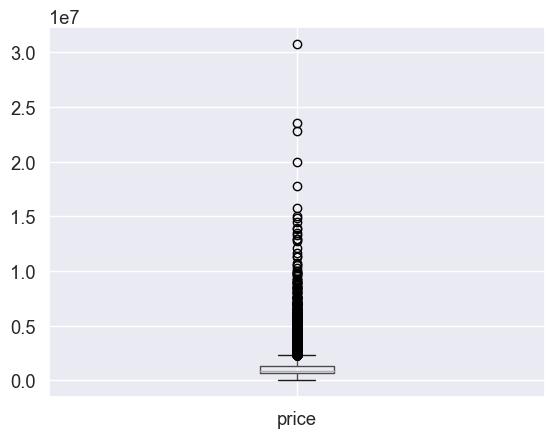

In [58]:
df_king.boxplot(column=['price'])

plt.show()

In [59]:
df_king.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29197 entries, 0 to 30154
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          29197 non-null  int64  
 1   price         29197 non-null  float64
 2   sqft_living   29197 non-null  int64  
 3   sqft_lot      29197 non-null  int64  
 4   waterfront    29197 non-null  int64  
 5   greenbelt     29197 non-null  int64  
 6   nuisance      29197 non-null  int64  
 7   view          29197 non-null  object 
 8   condition     29197 non-null  object 
 9   heat_source   29197 non-null  object 
 10  sewer_system  29197 non-null  object 
 11  sqft_patio    29197 non-null  int64  
 12  yr_renovated  29197 non-null  int64  
 13  lat           29197 non-null  float64
 14  long          29197 non-null  float64
 15  zipcode       29197 non-null  int32  
 16  renovated     29197 non-null  int32  
dtypes: float64(3), int32(2), int64(8), object(4)
memory usage: 3.8+ MB


In [60]:
df_king_final = df_king[(df_king['price'] <= 5000000)]

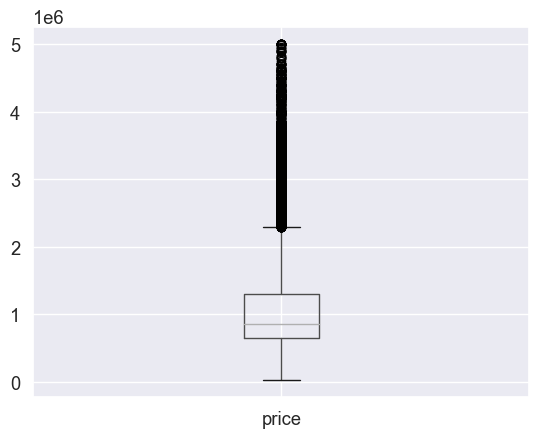

In [61]:
df_king_final.boxplot(column=['price'])

plt.show()

In [62]:
#df_king_final = df_king.copy()

In [63]:
#df_king_final['zipcode'].value_counts()

In [64]:
# Get unique zipcodes
unique_zipcodes2 = df_king_final['zipcode'].unique()

# Convert column 'zipcode' into dummy columns
df_zip2 = pd.get_dummies(df_king_final, columns=['zipcode'], prefix='zipcode')

# Create a list of new dummy zipcode columns
zip_col2 = [f"zipcode_{zipcode}" for zipcode in unique_zipcodes2]

# Define the most correlated column
most_correlated = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated_final = df_zip2[[most_correlated] + ['price']  + zip_col2 + ['renovated'] + ['waterfront']]

In [65]:
zip_dummy_final = X_iterated_final.drop('zipcode_98042', axis=1)

In [66]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=zip_dummy_final.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [67]:
print(df[(df.cc>.50) & (df.cc <1)])

                            cc
pairs                         
(price, sqft_living)  0.649515


In [68]:
y_final = zip_dummy_final['price']
x_final = zip_dummy_final.drop('price', axis = 1)
model_final = sm.OLS(y_final, sm.add_constant(x_final)).fit()

In [69]:
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     769.3
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:28:59   Log-Likelihood:            -4.1239e+05
No. Observations:               29002   AIC:                         8.250e+05
Df Residuals:                   28912   BIC:                         8.257e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.667e+04   1.64e+04     -4.668

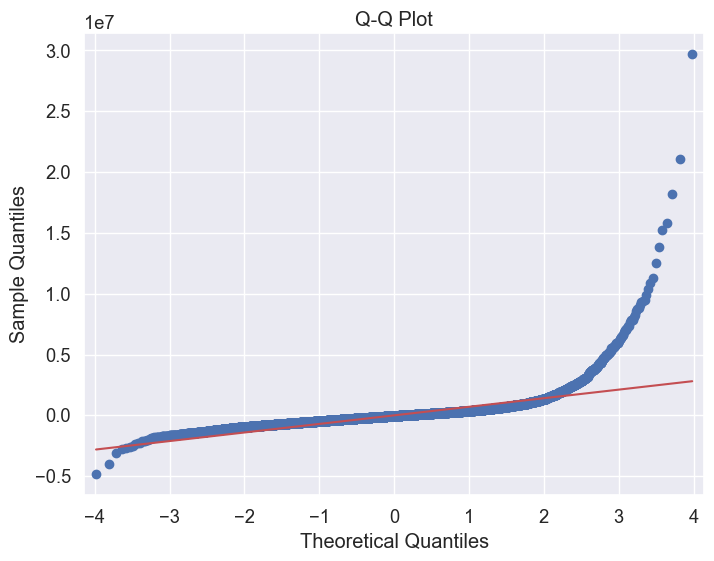

In [70]:
#Linearity
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(base_model.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

In [71]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(model_final.resid, sm.add_constant(x_final))

(2774.663158194437, 0.0, 34.36720411122385, 0.0)

In [72]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(model_final)

(1.0419589783195127, 0.006738513272625102)

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


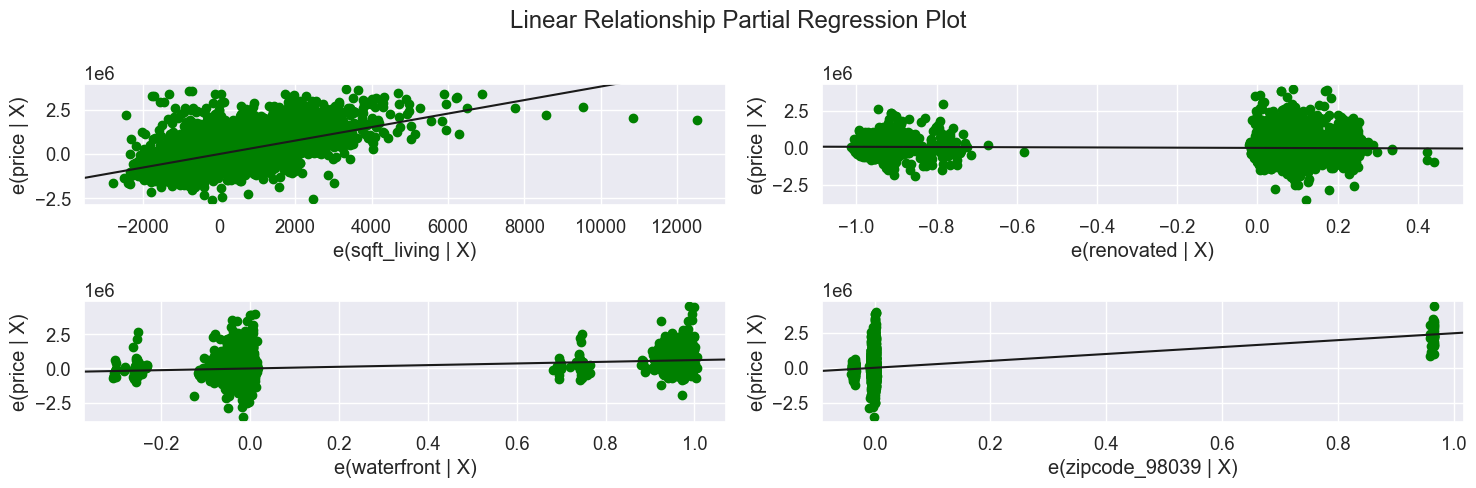

In [73]:
fig = plt.figure(figsize=(15,5))
sm.graphics.plot_partregress_grid(model_final, exog_idx=["sqft_living", "renovated", "waterfront", 'zipcode_98039'], fig=fig)

# Customizing plot appearance; note that the StatsModels code actually uses .plot
# with marker 'o', so what looks like a scatter plot is a "line" internally, so
# we access it using .lines rather than .collections
for ax in fig.axes:
    ax.lines[0].set_color("green")
fig.suptitle("Linear Relationship Partial Regression Plot", fontsize="large")

plt.tight_layout()
plt.show()

In [74]:
model_final_ex = sm.OLS(y_final, sm.add_constant(x_final))

In [75]:
n2 = model_final.nobs

# Taking the middle 50%, so ignoring the first 25% and last 25%
lower_bound = int(np.ceil(n2 * 0.25))
upper_bound = int(np.floor(n2 * 0.75))

# Take subsets of y and X
subset_y = model_final_ex.endog[lower_bound:upper_bound]
subset_X = model_final_ex.exog[lower_bound:upper_bound]

In [76]:
subset_model = sm.OLS(subset_y, subset_X)
subset_results = subset_model.fit()

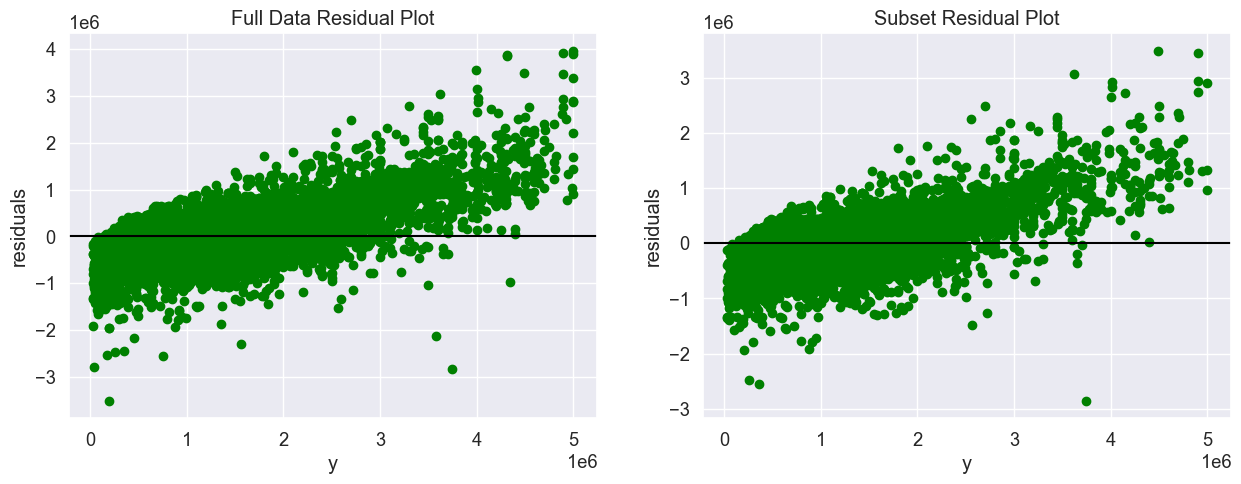

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

axes[0].scatter(model_final_ex.endog, model_final.resid, color="green")
axes[0].set_title("Full Data Residual Plot")

axes[1].scatter(subset_y, subset_results.resid, color="green")
axes[1].set_title("Subset Residual Plot")

for ax in axes:
    ax.set_xlabel("y")
    ax.set_ylabel("residuals")
    ax.axhline(y=0, color="black")

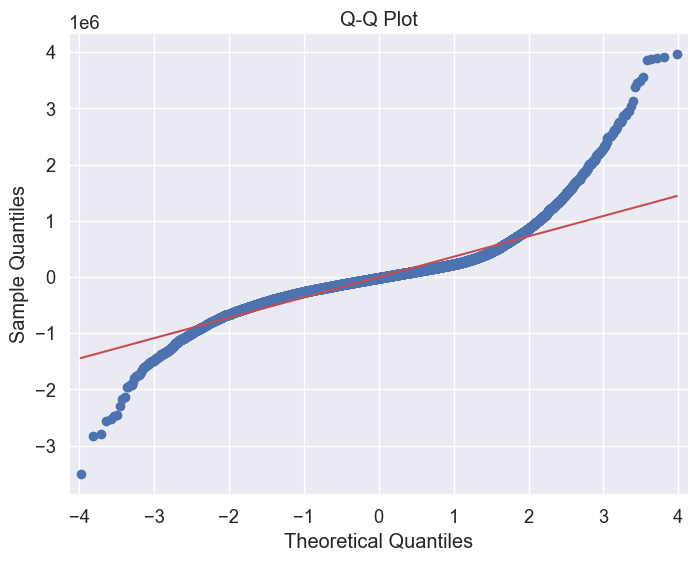

In [78]:
#qq plot to show normality

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_final.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

In [79]:
def plot_fit_lines(data, results, column, categories, interactions, cmap="plasma"):
    # Extract some shorter variable names for readability
    x = df_king_final["sqft_living"]
    beta_0 = results.params["const"]
    beta_1 = results.params["sqft_living"]
    
    # Set up scatter plot
    fig, ax = plt.subplots(figsize=(10,5))
    data.plot.scatter(x="sqft_living", y="price", c=column, cmap=cmap, alpha=0.5, ax=ax)

    colors = cm.get_cmap(cmap)
    min_cat = df_king_final[column].min()
    max_cat = df_king_final[column].max()
    range_cat = max_cat - min_cat
    
    # For each category, calculate and graph the fit line
    for cat in categories:
        if cat in interactions:
            fit_line = beta_0 + \
                (beta_1 + results.params[f"sqft_living x {column}_{cat}"]) * x + \
                results.params[f"{column}_{cat}"]
        else:
            fit_line = beta_0 + beta_1 * x + results.params[f"{column}_{cat}"]
            
        ax.plot(
            x,
            fit_line,
            color=colors((cat - min_cat)/range_cat),
            label=f"{column}: {cat}",
            linewidth=5,
            alpha=0.7)

    ax.legend();

In [80]:
df_king['date'].value_counts()

2021    18649
2022    10548
Name: date, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


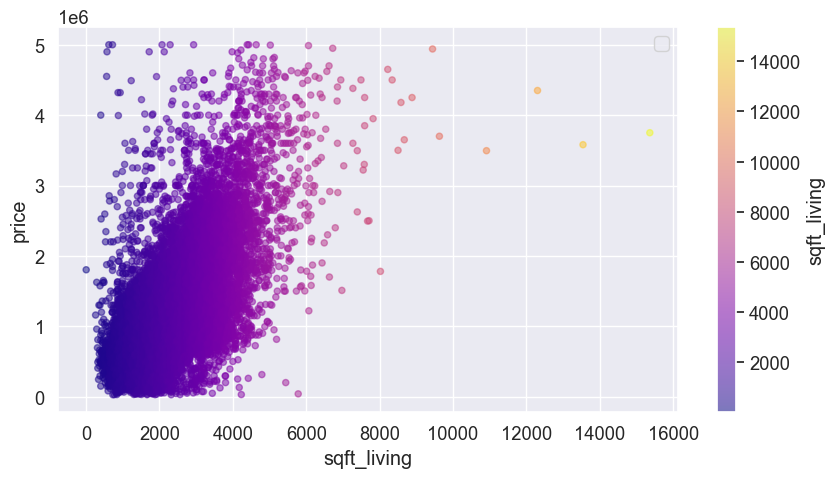

In [81]:
# Prepare data for modeling
y = df_king_final["price"]
X_no_interaction = df_king_final[["zipcode", "waterfront", "renovated", "sqft_living"]].copy()
X_no_interaction = pd.get_dummies(X_no_interaction, columns=["zipcode"], drop_first=True)

# Build model and get results
no_interaction_model = sm.OLS(y, sm.add_constant(X_no_interaction))
no_interaction_results = no_interaction_model.fit()

# Plot the lines generated by the model for each selected category
plot_fit_lines(df_king_final, no_interaction_results, "sqft_living", [], [])

# Part 6: Results

#### Base Model:
- Adjusted R-squared: 0.380
- F-statistic: 1.789e+04
- Prob (F-statistic): 0.00
- Df Model: 1
- Condition Number: 4.01e+05
- Multicollinearity: Might have strong multicollinearity problems

#### Final Model:
- Adjusted R-squared: 0.626
- F-statistic: 548.7
- Prob (F-statistic): 0.00
- Df Model: 89
- Condition Number: 4.01e+05
- Multicollinearity: Passes multicollinearity.   VIF score under 1.5


Final Model is better as it has a higher adjusted R-squared value (0.625 vs. 0.380), indicating that it explains more variation in housing prices. 

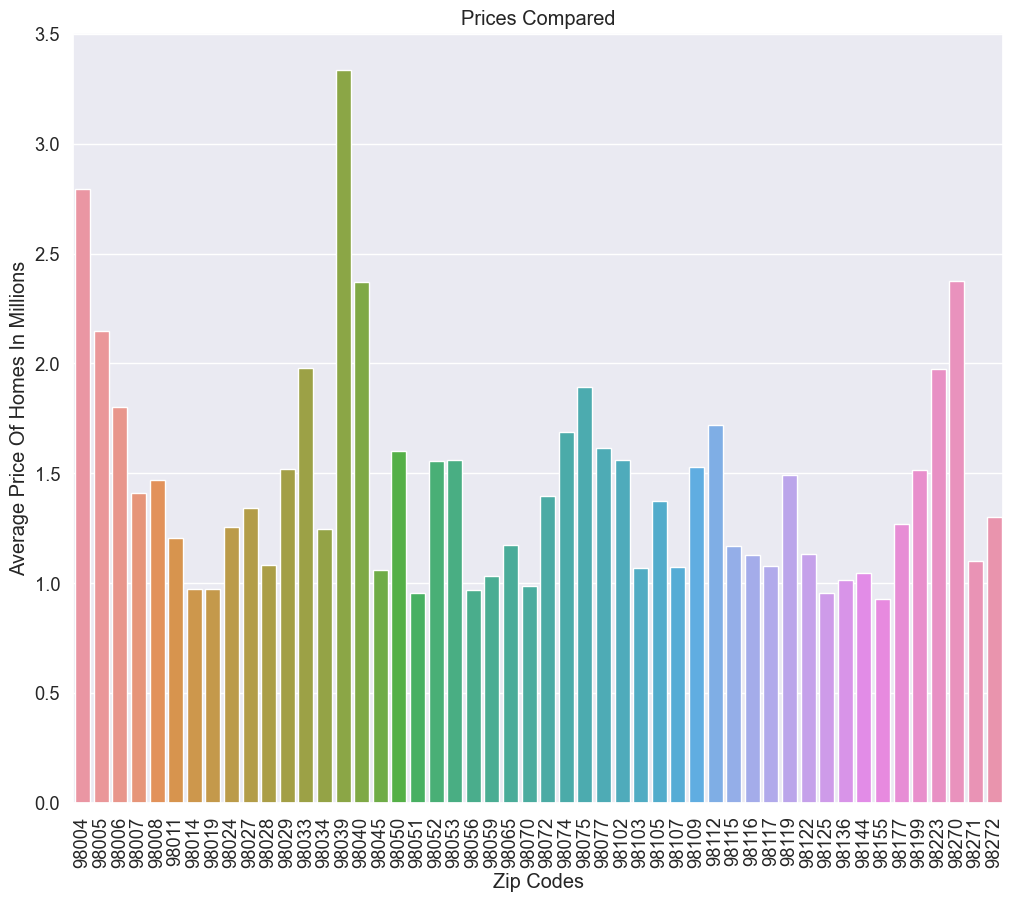

In [134]:
result = df_king_final.groupby(['zipcode'])['price'].mean().sort_values(ascending=False).head(50)

result# plot the result
fig, ax = plt.subplots(figsize=(12,10))

g=sns.barplot(x = result.index, y = result.values/1000000, )
g.set_xlabel('Zip Codes')
plt.xticks(rotation=90)
g.set_ylabel('Average Price Of Homes In Millions')
g.set_title('Prices Compared')

plt.savefig('images/Renovationprice.jpg')

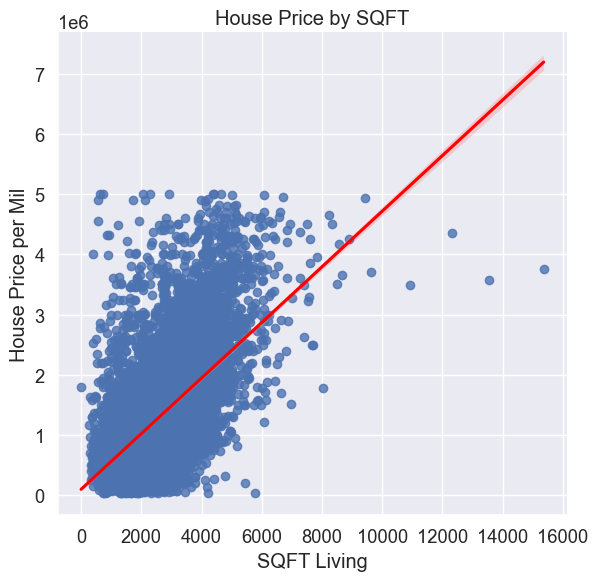

In [135]:
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", height=6, fit_reg=True, line_kws={"color": "red"})
plt.xlabel('SQFT Living')
plt.ylabel('House Price per Mil')
plt.title('House Price by SQFT')
plt.savefig('images/Renovationprice.jpg');

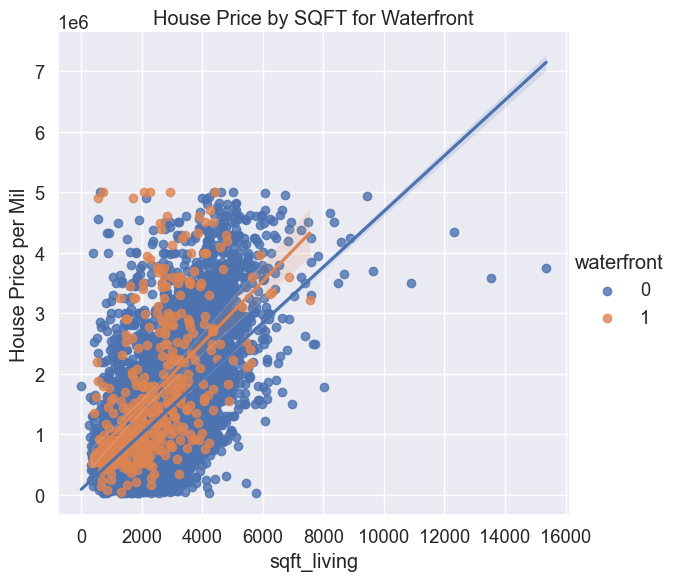

In [136]:
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", hue='waterfront', height=6, fit_reg=True)
plt.ylabel('House Price per Mil')
plt.title('House Price by SQFT for Waterfront')
plt.savefig('images/Waterfront.jpg');

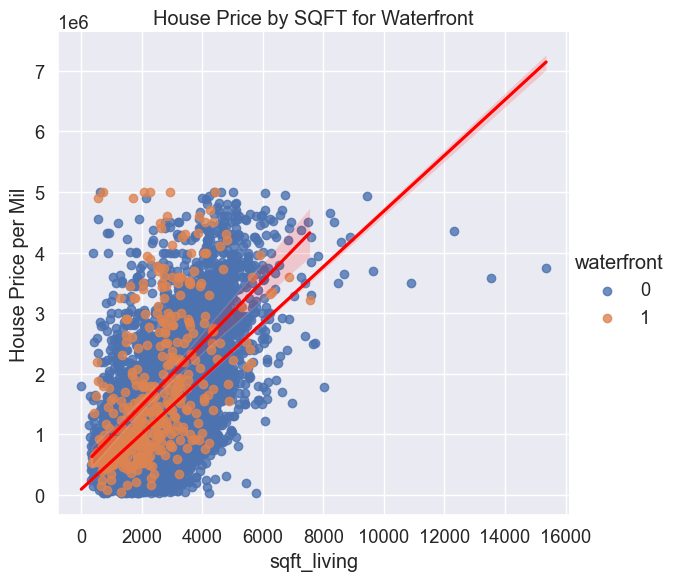

In [137]:
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", hue='waterfront', height=6, fit_reg=True, line_kws={"color": "red"})
plt.ylabel('House Price per Mil')
plt.title('House Price by SQFT for Waterfront')
plt.savefig('images/Waterfront.jpg');

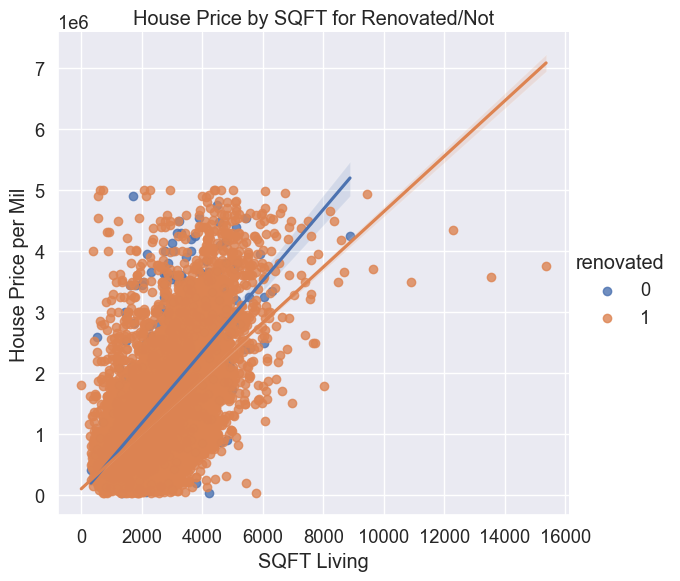

In [138]:
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", hue='renovated', height=6, fit_reg=True)
plt.xlabel('SQFT Living')
plt.ylabel('House Price per Mil')
plt.title('House Price by SQFT for Renovated/Not')
plt.savefig('images/renovated.jpg');

## Part 7: Conclusion 

Our final model features housing prices vs SQFT Living.   However, it takes into account Housing price vs SQFT Living for specific individual homes like waterfront homes/non waterfront homes and SQFT Living vs Housing price for renovated/unrenovated homes.

We see lots of potential for profit with unrenovated homes.   There are many more unrenovated homes than renovated homes in the market - thus we can choose many of these unrenovated homes, renovate them, increas their value, and earn profit.   

We satisify our initial business problem of being unsure what our plan of action is.   We now know our plan of action.   Choosing among 29,000 unrenovated homes (according to our data), we can increase their value by renovating them thus satisfying our intinial desire of maximizing profit.